# Classification de documents : President

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [3]:
import string
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer

class preprocessing():
    """
    All functions related to preprocessing
    """
    
    def __init__(self) -> None:   
        pass

    def do_all(self, text : tuple, my_punc : string = '\n\r\t') -> tuple:
        """
        Apply all the preprocessing function in one loop (to save time) (Except lemmatisation)
        """
        punc = string.punctuation  
        punc += my_punc
        return [(unicodedata.normalize('NFD'
                , re.sub('[0-9]+', ''
                , line.lower()
                .translate(str.maketrans(punc, ' ' * len(punc)))))
                .encode('ascii', 'ignore').decode("utf-8")
                .replace("  ", " ")
                .strip()
                ,pol) for line,pol in text]
    
    def remove_maj(self, text : tuple) -> tuple :
        """
        Return a tuple of text in lower case
        """
        return [(line.lower(),pol) for line,pol in text]

    def remove_punctuation(self, text  : tuple, my_punc : string = '\n\r\t') -> tuple :
        """
        Return a tuple of text without punctuation
        """
        punc = string.punctuation  
        punc += my_punc
        return [(line.translate(str.maketrans(punc, ' ' * len(punc))),pol) for line, pol in text]

    def remove_numbers(self, text : tuple) -> tuple :
        """
        Return a tuple of text without numbers
        """
        return [(re.sub('[0-9]+', '', line),pol) for line,pol in text]

    def remove_non_normalized_char(self, text : tuple) -> tuple :
        """
        Return a tuple of text without non normalized char
        """
        return [(unicodedata.normalize('NFD', line).encode('ascii', 'ignore').decode("utf-8"),pol) for line,pol in text]

    def get_line(self, text : tuple, sep : str = '\n', n : int = 0) -> tuple :
        """
        Returns a text list with the n-th line 
            - sep : string to recognize a new line
            - n : Integer of the line (0 = first, -1 = last)
        """
        return [(line.strip().split(sep)[n], pol) for line,pol in text]

    def remove_space(self, text : tuple) -> tuple:
        """
        Return a tuple of text without supernumerary space
        """
        return  [(line.replace("  ", " ").strip(), pol) for line,pol in text]

    def lemmatisation(self, text : tuple) -> tuple :
        """
        Return a lemmatized list 
        """
        # Téléchargez le stemmer français
        nltk.download('stopwords')
        nltk.download('punkt')
        nltk.download('rslp')

        # Créez un objet stemmer français
        stemmer = FrenchStemmer()
        l_words = [(nltk.word_tokenize(line),pol) for line,pol in text]
        stemmed_words = [([stemmer.stem(word) for word in line],pol) for line,pol in l_words]
        # print(stemmed_words)
        return [(" ".join(line),pol) for line,pol in stemmed_words]


In [4]:
president_path_train = "./ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
president_path_test = "./ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

# Parsing
palltxts_train, palllabs_train = load_pres(president_path_train)
palltxts_test, palllabs_test = load_pres(president_path_test)

# Zip in tuple
p_train = list(zip(palltxts_train, palllabs_train))
p_test = list(zip(palltxts_test, palllabs_test))

In [5]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


<BarContainer object of 2 artists>

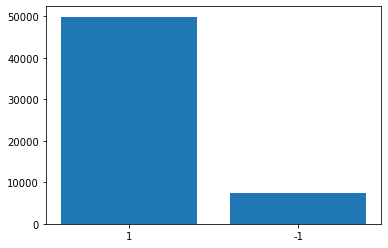

In [6]:
val = []
val.append(len([x for x in palllabs_train if x == 1]))
val.append(len([x for x in palllabs_train if x == -1]))
label = ['1', '-1']
plt.bar(label,val) # Il y a un désequilibre dans notre échantillon, il est fortement probable que -1 soit beaucoup moins bien predit...

# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [7]:
# Testing preprocessing functions

preprocessor = preprocessing()

# President
two_line = p_train[0:2]
two_line[0] = ('   999' + two_line[0][0], two_line[0][1])
print("Normal text :")
print(two_line)

print("\nMinuscule :")
print(preprocessor.remove_maj(two_line))

print("\nNumbers :")
print(preprocessor.remove_numbers(two_line))

print("\nNormalized char :")
print(preprocessor.remove_non_normalized_char(two_line))

print("\npunctuation :")
print(preprocessor.remove_punctuation(two_line))

print("\nSpace :")
print(preprocessor.remove_space(two_line))

print("\nLemmatisation :")
print(preprocessor.lemmatisation(two_line))

print("\nGet line :") # Here as the separator use is a space it will get the last word
print(preprocessor.get_line(two_line, sep = ' ', n = -1))

print("\nAll :")
print(preprocessor.do_all(two_line))

Normal text :
[("   999 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.\n", 1), (" D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.\n", 1)]

Minuscule :
[("   999 quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.\n", 1), (" d'abord merci de cet exceptionnel accueil que les congolais, les brazavillois, nous ont réservé cet après-midi.\n", 1)]

Numbers :
[("    Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.\n", 1), (" D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.\n", 1)]

Normalized char :
[("   999 Quand je dis chers amis, il ne s'agit pas la d'une formule diplomatique, mais de l'expression de ce que je ressens.\n", 1), (" D'abord merci de cet exceptionnel accu

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gardette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gardette/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /home/gardette/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [8]:
# Preprocessing Text

# President 
## Train
p_train = preprocessor.do_all(p_train)

# p_train = preprocessor.lemmatisation(p_train)

## Test
p_test = preprocessor.do_all(p_test)
# p_test = preprocessor.lemmatisation(p_test)

# Movie
# TODO

# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud] 
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


In [9]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import math
from scipy import special
from gensim import corpora
import operator
import numpy as np

class voc_extracting():

    def __init__(self) -> None:
        self.vectorizer = CountVectorizer()


    def get_size(self, text : tuple) -> int :
        """
        Return the size of a vocabulary
        """
        corpus = [line for line,pol in text]
        self.vectorizer.fit_transform(corpus)
        return len(self.vectorizer.get_feature_names_out())
   
    def get_tf_idf(self, text : tuple, n : int = 100) -> list :
        """
        Return the list of n words the most frequent according to TF-IDF
        """
        corpus = [line for line,pol in text]
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(corpus)

        scores = zip(vectorizer.get_feature_names_out(),
                 np.asarray(X.sum(axis=0)).ravel())

        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        return [w[0] for w in sorted_scores[:n]]
    
    def get_most_freq_word(self, text : tuple, n : int = 100) -> list :
        """
        Return the list of n words the most frequent
        """
        corpus = [line for line,pol in text]
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(corpus)
        sum_words = X.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return [w for w,f in words_freq[:n]]

    def get_ngram(self, text : tuple, n : int = 100, size : int = 2) -> list :
        """
        Return the list of n words the most frequent associated by group of "size" words
        """
        vectorizer = CountVectorizer(ngram_range=(size, size))
        corpus = [line for line,pol in text]
        X = vectorizer.fit_transform(corpus)
        sum_words = X.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return [w for w,f in words_freq[:n]]

    def plot_Zipf_distribution(self, text : tuple, n : int = 100) -> list :
        """
        Plot the Zipf distribution of a text according to word frequency
        """
        corpus = [line for line,pol in text]
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(corpus)
        sum_words = X.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        freqs = [f for w,f in words_freq]

        # Plot
        rank = list(np.arange(1,len(freqs) +1))
        plt.figure(figsize=(10,10))
        plt.plot(np.log(rank), np.log(freqs))
        plt.xlabel('log(Rank)')
        plt.ylabel('log(Frequency)')
        plt.title('Zipf Distribution')
        plt.savefig('./output/zipf_distribution.png', transparent = True)
        plt.show()

    def word_cloud(self, corpus : list, stop_word : list = None) -> None :
        """
        Display word cloud
        """
        corpus = ' '.join(corpus)
        wordcloud = WordCloud(stopwords = stop_word).generate(corpus)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")

    def get_ngram_letter(self, text : tuple, n : int = 100, size : int = 2) -> list :
        """
        Return the list of n word the most frequent associated by group of "size" letter
        """
        vectorizer = CountVectorizer(ngram_range=(size, size), analyzer='char_wb', stop_words= ' ')
        corpus = [line for line,pol in text]
        X = vectorizer.fit_transform(corpus)
        sum_words = X.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return [w.strip() for w,f in words_freq[:n]]

    def odd_ratio(self, p : float, q : float) -> int:
        """
        Calculate odd ratios from the frequencies p and q
        """
        if p not in [0,1] and q not in [0,1]:
            OR = (p*(1-q)) / (q*(1-p))
            return OR
        else:
            return 0
    
    def get_oddratio(self, text : tuple, n : int = 100) -> list :
        """
        Return  the list of n word the most frequent according to the odd ratio
        """
        vectorizer = CountVectorizer()
        corpus = [line for line,pol in text]
        X = vectorizer.fit_transform(corpus)

        #transform

        corpus1 = [line for line,pol in text if pol == 1]
        corpus2 = [line for line,pol in text if pol == -1]
        X_class1 = vectorizer.transform(corpus1)
        X_class2 = vectorizer.transform(corpus2)

        sum_words1 = X_class1.sum(axis=0)
        sum_words2 = X_class2.sum(axis=0)

        n_voc = len(vectorizer.vocabulary_)
        words_freq1 = [(word, sum_words1[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq2 = [(word, sum_words2[0, idx]) for word, idx in vectorizer.vocabulary_.items()]


        odd_ratios = [(word, self.odd_ratio(words_freq1[idx][1]/n_voc, words_freq2[idx][1]/n_voc)) for word, idx in vectorizer.vocabulary_.items()]
        odd_ratios = sorted(odd_ratios, key = lambda x: x[1], reverse=True)
        return [word for word,freq in odd_ratios[:n]]

    def get_doc_freq(self, text : tuple, n : int = 100) -> list :
        """
        Return the list of n words with the highest documentary frequency
        """
        vectorizer = CountVectorizer()
        corpus = [line for line,pol in text]
        X = vectorizer.fit_transform(corpus)
        words_freq = [(word, (np.transpose(X)[idx]!=0).sum(axis=1)[0,0]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return [word for word, freq in words_freq[:n]]



Quelle est la taille d'origine du vocabulaire?
Size Voc :
27054

Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
Most frequent words (100)


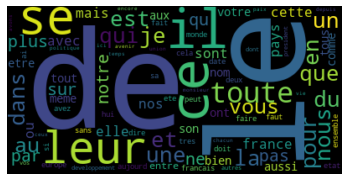

In [10]:
extractor = voc_extracting()

print("Quelle est la taille d'origine du vocabulaire?")
print("Size Voc :")
print(extractor.get_size(p_train))

print("\nQue reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]")
print("Most frequent words (100)")
most_freq_100 = extractor.get_most_freq_word(p_train, 100)
# print(most_freq_100) # Beaucoup de stop word, premier mot intéressant à l'index 35 -> france
extractor.word_cloud(most_freq_100)

(Bonus) les 100 mots les plus fréquents selon la fréquence tf-idf? [word cloud]

TF-IDF (100) :


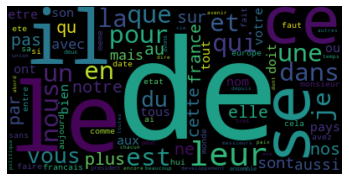

In [11]:
print("(Bonus) les 100 mots les plus fréquents selon la fréquence tf-idf? [word cloud]")
print("\nTF-IDF (100) :")
tf_idf_100 = extractor.get_tf_idf(p_train, 100)
# print(tf_idf_100) # le mot france est mieux classé, diminution de l'influence des stop word
extractor.word_cloud(tf_idf_100)

Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

Documentary frequency (100) :
['de', 'la', 'et', 'le', 'les', 'des', 'est', 'en', 'que', 'qui', 'un', 'une', 'dans', 'pour', 'du', 'il', 'je', 'nous', 'au', 'vous', 'ce', 'plus', 'pas', 'qu', 'sur', 'notre', 'france', 'ne', 'par', 'cette', 'mais', 'avec', 'aussi', 'se', 'nos', 'pays', 'ou', 'sont', 'elle', 'ont', 'aux', 'etre', 'tout', 'tous', 'votre', 'leur', 'son', 'bien', 'nom', 'ces', 'meme', 'comme', 'hui', 'aujourd', 'on', 'entre', 'doit', 'europe', 'monde', 'faire', 'ses', 'sa', 'francais', 'ai', 'faut', 'ils', 'si', 'ete', 'sans', 'fait', 'etat', 'date', 'cela', 'dire', 'ensemble', 'avez', 'peut', 'deux', 'developpement', 'dont', 'tres', 'leurs', 'encore', 'politique', 'autres', 'president', 'monsieur', 'toutes', 'vie', 'avons', 'vos', 'ici', 'ceux', 'depuis', 'temps', 'toute', 'chacun', 'avenir', 'paix', 'union']


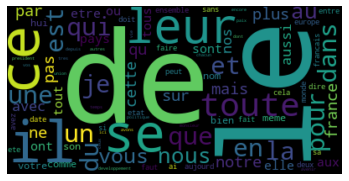

In [12]:
print("Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]")
print("\nDocumentary frequency (100) :")
doc_freq_100 = extractor.get_doc_freq(p_train, 100)
print(doc_freq_100)
# print(tf_idf_100) # le mot france est mieux classé, diminution de l'influence des stop word
extractor.word_cloud(doc_freq_100)

Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

ODD ratio (100) :


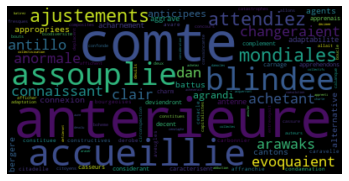

In [13]:
print("Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]")
print("\nODD ratio (100) :")
odd_100 = extractor.get_oddratio(p_train, 100)
# print(odd_100)
# print(tf_idf_100) # le mot france est mieux classé, diminution de l'influence des stop word
extractor.word_cloud(odd_100)

Quelle est la distribution d'apparition des mots (Zipf)

Zipf dsistribution (100) :


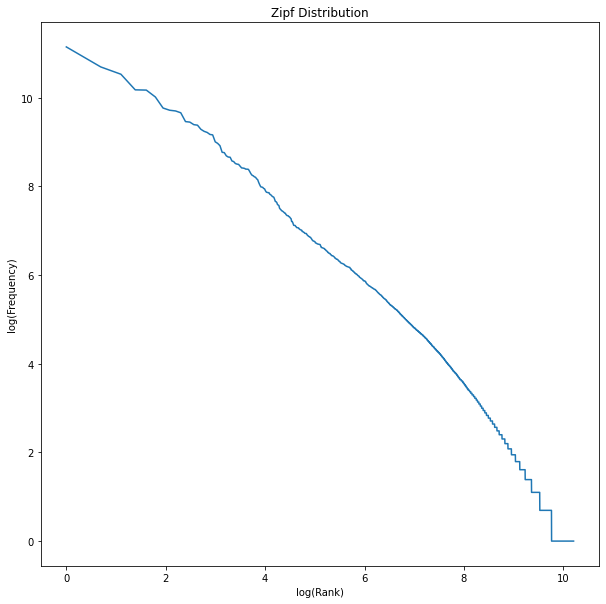

None


In [14]:
print("Quelle est la distribution d'apparition des mots (Zipf)")
print("\nZipf dsistribution (100) :")
print(extractor.plot_Zipf_distribution(p_train, 100)) # le mot france est mieux classé, diminution de l'influence des stop word

Quels sont les 100 bigrammes/trigrammes les plus fréquents?

Ngram 2 (100) :


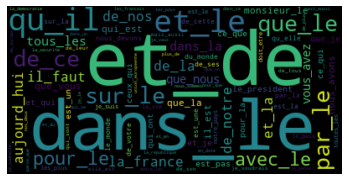

In [15]:
print("Quels sont les 100 bigrammes/trigrammes les plus fréquents?")
print("\nNgram 2 (100) :")
ngram_2 = extractor.get_ngram(p_train, 100, 2)
ngram_2 = [string.replace(' ', '_') for string in ngram_2]
# print(ngram_2)
extractor.word_cloud(ngram_2)


Ngram 3 (100) :


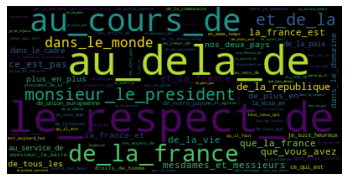

In [16]:
print("\nNgram 3 (100) :")
ngram_3 = extractor.get_ngram(p_train, 100, 3)
ngram_3 = [string.replace(' ', '_') for string in ngram_3]
# print(ngram_3)
extractor.word_cloud(ngram_3)

Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?


Les avantages de cette approche comprennent une meilleure précision, une plus grande robustesse et une réduction des problèmes de sur-apprentissage. De plus, le modèle de tri-grammes de lettres est relativement simple à mettre en œuvre et peut être appliqué à une variété de domaines.

Les inconvénients de cette approche peuvent inclure une complexité accrue et une plus grande consommation de ressources. De plus, le modèle peut être sujet à des erreurs d'interprétation et des problèmes liés à la taille de l'échantillon..

st-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Ngram letter 3 (100) :
['de', 'la', 'ent', 'et', 'les', 'l', 'a', 'tion', 'que', 'ion', 'les', 'le', 'ment', 'des', 'des', 'ous', 'tre', 'd', 'atio', 'emen', 'que', 'con', 'est', 'est', 'ons', 'en', 'par', 'qui', 'ite', 'qui', 'ans', 'pou', 'nce', 'elle', 'pour', 'res', 'une', 'our', 'un', 'une', 'nou', 'ique', 'ance', 'ont', 'dan', 'ire', 'tou', 'dans', 'com', 'ais', 'lle', 'tes', 'vou', 'du', 'pro', 'eur', 'ranc', 'je', 'fra', 'pre', 'ions', 'il', 'fran', 'aire', 'nous', 'otre', 'vous', 'urs', 'ant', 'leur', 'ouve', 'ave', 'au', 'ait', 'plu', 'eux', 'ces', 'ce', 'c', 'lus', 'plus', 'son', 'pas', 'ntre', 'tout', 'ses', 'mon', 'aux', 'omme', 'not', 'comm', 'sur', 'eurs', 'mai', 'ent', 'part', 'onne', 'mes', 'pres', 'qu']


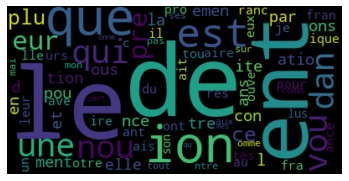

In [17]:
print("st-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?")
print("\nNgram letter 3 (100) :")
lngram_3 = extractor.get_ngram_letter(p_train, 100, 4)
print(lngram_3)
extractor.word_cloud(lngram_3) # Peut sans doute être utile pour choisir des stop words en masse

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

## Réponses :

Le temps nécessaire pour apprendre un classifieur NB/SVM/RegLog sur des données est proportionnel à la taille du vocabulaire. Plus le vocabulaire est grand, plus le temps de formation sera long. Plus précisément, on peut dire que le temps de formation est approximativement égal à:

T = K * V

Où T est le temps de formation, K est un facteur constant qui dépend du type de classifieur et du jeu de données, et V est la taille du vocabulaire.


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

class model():

    def __init__(self) -> None:
        self.vectorize()

    def vectorize(self, lower : bool = True, stripaccents : str = None, stop_words : list = None, gram1 : int = 1, gram2 : int = 1, maxdf :int = 1, mindf : int = 1, maxf : int = any):
        # self.vectorizer = TfidfVectorizer(input = 'content'         , lowercase = lower , strip_accents = stripaccents
        #                                 , stop_words = stop_words   , ngram_range = (gram1,gram2)   , analyzer = 'word')
        self.vectorizer = CountVectorizer(input = 'content'         , lowercase = lower , strip_accents = stripaccents
                                        , stop_words = stop_words   , ngram_range = (gram1,gram2)   , analyzer = 'word')

    def split_tuple(self, text : tuple):
        """
        Split tuple and return classes with sparse matrice (ready to train)
        """
        classes = [pol for line,pol in text if len(line)]
        corpus = [line for line,pol in text if len(line)]
        X_train = self.vectorizer.fit_transform(corpus)
        return classes, X_train

    def mod_nb(self, text : tuple) :
        """
        Naives Bayes
        """
        classes, X_train = self.split_tuple(text)
        nb_clf = MultinomialNB()
        nb_clf.fit(X_train, classes)
        return nb_clf

    def mod_logReg(self, text : tuple, state : int = 0, my_solver : str = 'lbfgs', job : int = -1):
        """
        Logistic Regression
        """
        classes, X_train = self.split_tuple(text)
        lr_clf = LogisticRegression(random_state = state, solver = my_solver,n_jobs = job, C = 1e-5)
        lr_clf.fit(X_train, classes)
        return lr_clf

    def mod_svm(self, text : tuple, state : int = 0, eps : int = 1e-5):
        """
        Linear SVM
        """
        classes, X_train = self.split_tuple(text)
        svm_clf = LinearSVC(random_state = state, C = eps)
        svm_clf.fit(X_train, classes)
        return svm_clf

    def cross_validation(self, mod, text : tuple, fold : int = 100) -> int:
        """
        Return cross validation score
        """ 
        y, X = self.split_tuple(text)
        kf = KFold(n_splits = fold, shuffle = True)
        return cross_val_score(mod, X, y, cv = kf)

    def mod_predict(self, text : tuple, mod):
        """
        Predict text for all the model given in param
        """
        corpus = [line for line,pol in text if len(line)]
        X_test = self.vectorizer.transform(corpus)
        pred = mod.predict(X_test)
        return pred
    
    def display_score(self, text : tuple,  pred : list, name : list):
        """
        Print scores
        """
        classes = [pol for line,pol in text if len(line)]
        l_score = []
        for score,name in zip(pred,name) :
            res = accuracy_score(classes, score)
            l_score.append(res)
            print(f"Score {name} : {res}")
        return l_score
    
    def display_bar(self, y_value : list, x_value : list):
        plt.bar(x_value, y_value)
        # plt.xticks(range(0, len(x_value)), x_value, size=7)
        # plt.xticks(rotation='vertical')
        plt.ylabel('accuracy')
        plt.show()


In [19]:
# testing
modelizator = model()
modelizator.vectorize(lower = True, stop_words = None, maxdf = 1, mindf = 1)

pred = []

mod_nb = modelizator.mod_nb(p_train)
pred.append(modelizator.mod_predict(p_test,mod_nb))

mod_logReg = modelizator.mod_logReg(p_train)
pred.append(modelizator.mod_predict(p_test,mod_logReg))

mod_svm = modelizator.mod_svm(p_train)
pred.append(modelizator.mod_predict(p_test,mod_svm))

modelizator.display_score(p_test, pred, ['mod_nb', 'mod_logReg', 'mod_svm'])

# Accuracy

# Score mod_nb : 0.8074685129262724
# Score mod_logReg : 0.8925388524710908
# Score mod_svm : 0.8925388524710908

# F1 Score
# Score mod_nb : 0.892045923845709
# Score mod_logReg : 0.9432185250048648
# Score mod_svm : 0.9432185250048648

Score mod_nb : 0.8074685129262724
Score mod_logReg : 0.8925388524710908
Score mod_svm : 0.8925388524710908


[0.8074685129262724, 0.8925388524710908, 0.8925388524710908]

In [20]:
# Cross validation
print(modelizator.cross_validation(mod_nb, p_train, 10))
print(modelizator.cross_validation(mod_logReg, p_train, 10))
print(modelizator.cross_validation(mod_svm, p_train, 10))

# Cross validation est plus ou moins stable

[0.88323458 0.88672011 0.88166609 0.88166609 0.88462879 0.88445451
 0.88495729 0.88565452 0.88251699 0.88722329]
[0.8680725  0.87452074 0.86702684 0.86650401 0.87190659 0.86371558
 0.86491197 0.87136134 0.86892104 0.87205857]
[0.86720112 0.87155803 0.86737539 0.86563262 0.86598118 0.87155803
 0.87188426 0.87014119 0.86892104 0.86874673]


## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

In [21]:
train = p_train
test = p_test

X_train = [line for line,pol in train]
y_train = [pol for line,pol in train]
X_test = [line for line,pol in test]
y_test = [pol for line,pol in test]

In [22]:
# Stop Word
extractor = voc_extracting()

stop1 = extractor.get_most_freq_word(train, 28) # position 29 = france
stop2 = extractor.get_tf_idf(train, 26) # position 27 = france
stop3 = extractor.get_ngram_letter(train, 100000, 4)

### Naive Baye

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# Pipeline & Gridsearch setup
# Pipeline Setup
tvc_pipe = Pipeline([
                     ('tvec', CountVectorizer()),
                    #  ('tvec', TfidfVectorizer()),
                     ('mb', MultinomialNB())
                    ])
#fit
tvc_pipe.fit(X_train, y_train)

# Setting params for bayesian Vectorizer gridsearch
tf_params = {
    'tvec__lowercase': [True],
    # 'tvec__lowercase': ['True', 'False'],
    'tvec__analyzer' : ['word'],
    # 'tvec__analyzer' : ['word', 'char', 'char_wb'],
    'tvec__decode_error': ['strict'],
    # 'tvec__decode_error': ['strict', 'ignore', 'replace'],
    'tvec__strip_accents': [None],
    # 'tvec__strip_accents': [None, 'ascii', 'unicode'],
    'tvec__stop_words': [None],
    # 'tvec__stop_words': [None, stop1, stop2, stop3],
    'tvec__min_df': [0.1],
    # 'tvec__min_df': [0.1,0.2],
    'tvec__max_df': [0.5],
    # 'tvec__max_df': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    # 'tvec__max_features': [10000],
    'tvec__max_features': [10, 100 ,2000, 5000],
    'tvec__ngram_range': [(1,4)],
    # 'tvec__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
}
# Display params we can use
# CountVectorizer().get_params().keys()
# TfidfVectorizer().get_params().keys()

In [24]:
# Setting up GridSearch for Randomforest
score =  'accuracy'  #'accuracy' # 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score'
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, scoring =  score, cv = 5, verbose =1, n_jobs = -1)
tvc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', CountVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__analyzer': ['word'],
                         'tvec__decode_error': ['strict'],
                         'tvec__lowercase': [True], 'tvec__max_df': [0.5],
                         'tvec__max_features': [10, 100, 2000, 5000],
                         'tvec__min_df': [0.1], 'tvec__ngram_range': [(1, 4)],
                         'tvec__stop_words': [None],
                         'tvec__strip_accents': [None]},
             scoring='accuracy', verbose=1)

In [25]:
# Scoring Training data
print(tvc_gs.score(X_train, y_train))
print(tvc_gs.score(X_test, y_test))

0.8698726769198614
0.8889993373094764


In [26]:
tvc_gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__decode_error': 'strict',
 'tvec__lowercase': True,
 'tvec__max_df': 0.5,
 'tvec__max_features': 100,
 'tvec__min_df': 0.1,
 'tvec__ngram_range': (1, 4),
 'tvec__stop_words': None,
 'tvec__strip_accents': None}

### Results Naïve Baye

Best score for Bayesien with countvectorize

train = 0.8698726769198614 \
test = 0.8889993373094764

{'tvec__analyzer': 'word', \
 'tvec__decode_error': 'strict',  \
 'tvec__lowercase': True, \
 'tvec__max_df': 0.5, \
 'tvec__max_features': 100, \
 'tvec__min_df': 0.1, \
 'tvec__ngram_range': (1, 4), \
 'tvec__stop_words': None, \
 'tvec__strip_accents': None}

Best score for Bayesien with TfidfVectorizer

train = 0.8689669587027329\
test = 0.8925705029084751

{'tvec__analyzer': 'word', \
 'tvec__decode_error': 'strict',  \
 'tvec__lowercase': True, \
 'tvec__max_df': 0.5, \
 'tvec__min_df': 0.1, \
 'tvec__max_features': 100, \
 'tvec__ngram_range': (1, 1), \
 'tvec__stop_words': None, \
 'tvec__strip_accents': None}

 Le meilleur score pour naïve baye est obtenu avec la fréquence TF-IDF

### Logistic regression

In [27]:
train = p_train
test = p_test

X_train = [line for line,pol in train]
y_train = [pol for line,pol in train]
X_test = [line for line,pol in test]
y_test = [pol for line,pol in test]

In [28]:
from sklearn.model_selection import GridSearchCV

# Setting params for Logistic Regression gridsearch
LG_params = {
    'C': [1e-5],
    # 'C': [1e-5,, 0.001, 0.01, 0.1, 0.5,< 0.9],
    'random_state': [1],
    'penalty': ['l2'],
    # 'penalty': ['l1', 'l2'],
    'solver': ['lbfgs'],
    # 'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg' ],
    # 'class_weight': [{-1:3.81583145 , 1: 0.57539587 }],
    'max_iter': [100] 
    }
# Display params we can use
# LogisticRegression().get_params().keys()

In [29]:
# Setting up GridSearch for Logistic Regression
model = LogisticRegression()
vectorizer = CountVectorizer(ngram_range=(1,3), max_df=0.6, min_df=0.08, lowercase=True, stop_words=stop1) # Pas d'influance en changeant avec TF-idf
vectors = vectorizer.fit_transform(X_train)
score = 'accuracy' # 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score'
LG_gs = GridSearchCV(model, param_grid=LG_params, cv = 5)# Fitting TVC GS
LG_gs.fit(vectors, y_train)# Fitting Randomforest CV GS

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05], 'max_iter': [100], 'penalty': ['l2'],
                         'random_state': [1], 'solver': ['lbfgs']})

In [30]:
# Scoring Training data
vectors_test = vectorizer.transform(X_test)
print(LG_gs.score(vectors, y_train))
print(LG_gs.score(vectors_test, y_test))

0.8689669587027329
0.8925705029084751


In [31]:
LG_gs.best_params_

{'C': 1e-05,
 'max_iter': 100,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs'}

### Result

0.8689669587027329 \
0.8925705029084751

{'C': 1e-05, 'n_jobs': -1, 'random_state': 1, 'solver': 'lbfgs'}

Le score obtenu est légèrement mieux qu'avec les paramètres par défault(0.8925388524710908) mais ce n'est pas impressionant.

### SVM

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_ind = le.fit_transform(y_train)
recip_freq = len(y_train) / (len(le.classes_) * np.bincount(y_ind).astype(np.float64))
weight = recip_freq[le.transform(np.unique(y_train))]
print(weight)

LSVC_params = {
    'C':[0.0001],
    # 'C':[0.00001, 0.0001, 0.001],
    # 'class_weight':['balanced'], 
    'class_weight':[None, 'balanced'], 
    'penalty': ['l2'],
    # 'penalty': ['l1', 'l2'],
    # 'class_weight': [{1:3.81583145 , -1: 0.57539587 }],
    'loss' : ['hinge'],
    # 'loss' : ['hinge', 'squared_hinge'],
    }
# Display params we can use
LinearSVC().get_params().keys()

[3.81583145 0.57539587]


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [33]:
# Setting up GridSearch for Logistic Regression
model = LinearSVC()
vectorizer = CountVectorizer(ngram_range=(1,3)) # Pas d'influance en changeant avec TF-idf
vectors = vectorizer.fit_transform(X_train)
score = 'accuracy' # 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score'
LSVC_gs = GridSearchCV(model, param_grid=LSVC_params, cv = 5)# Fitting TVC GS
LSVC_gs.fit(vectors, y_train)# Fitting Randomforest CV GS

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.0001], 'class_weight': [None, 'balanced'],
                         'loss': ['hinge'], 'penalty': ['l2']})

In [34]:
# Scoring Training data
vectors_test = vectorizer.transform(X_test)
print(LSVC_gs.score(vectors, y_train))
print(LSVC_gs.score(vectors_test, y_test))

0.8689669587027329
0.8925705029084751


In [35]:
LSVC_gs.best_params_
# sklearn.metrics.SCORERS.keys()

{'C': 0.0001, 'class_weight': None, 'loss': 'hinge', 'penalty': 'l2'}

0.8689669587027329\
0.8925705029084751

{'C': 1e-05, 'class_weight': None}

### Result

Les résultats sont commme notre régression linéaire.

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Définir les paramètres à tester
RF_params = {'n_estimators': [10], 
            # 'n_estimators': [10, 50, 100], 
            'criterion': ['entropy'],
            'max_features': ['sqrt'],
            # 'max_features': ['auto', 'sqrt', 'log2'], 
            'max_depth': [10],
            # 'max_depth': [3, 5, 7, 10]
            'bootstrap': [True],
            'class_weight': [None],
            # 'class_weight': [None, 'balanced', 'balanced_subsample'],
            'ccp_alpha': [0.001],
            # 'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]
    }
# Display params we can use
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [37]:
# Setting up GridSearch for Random Forest
model = RandomForestClassifier()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=None) # Pas d'influance en changeant avec TF-idf
vectors = vectorizer.fit_transform(X_train)
score = 'accuracy' # 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score'
RF_gs = GridSearchCV(model, param_grid=RF_params, scoring = score,  cv = 5)
RF_gs.fit(vectors, y_train)# Fitting Randomforest

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.001],
                         'class_weight': [None], 'criterion': ['entropy'],
                         'max_depth': [10], 'max_features': ['sqrt'],
                         'n_estimators': [10]},
             scoring='accuracy')

In [38]:
# Scoring Training data
vectors_test = vectorizer.transform(X_test)
print(RF_gs.score(vectors, y_train))
print(RF_gs.score(vectors_test, y_test))

0.8689669587027329
0.8925705029084751


In [39]:
RF_gs.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.001,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 10}

### Result

De toute évidence nous restons bloqué sur le même score que la régression linéaire ou une SVM. Notre désequilibre de départ peut sans doute être lié ou bien nous avons mal fait quelque chose.

## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [40]:
# Test 1
# Pour rappel il y a 49890  1 et 7523 -1

stock = list(zip(palltxts_train , palllabs_train))
plus_stock = [(txt,pol) for txt,pol in stock if pol == 1]
minus_stock = [(txt,pol) for txt,pol in stock if pol == -1]
reduce_train = plus_stock[:7523] + minus_stock


X_train = [line for line,pol in reduce_train]
y_train = [pol for line,pol in reduce_train]

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Définir les paramètres à tester
RF_params = {'n_estimators': [10], 
            # 'n_estimators': [10, 50, 100], 
            'criterion': ['entropy'],
            # 'max_features': ['sqrt'],
            'max_features': ['auto', 'sqrt', 'log2'], 
            # 'max_depth': [10],
            'max_depth': [3, 5, 7, 10],
            'bootstrap': [True],
            # 'class_weight': [None],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
            'ccp_alpha': [0.001],
            # 'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]
    }
# Display params we can use
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [42]:
# Setting up GridSearch for Random Forest
model = RandomForestClassifier()
vectorizer = TfidfVectorizer(ngram_range=(1,4), stop_words=stop1) # Pas d'influance en changeant avec TF-idf
vectors = vectorizer.fit_transform(X_train)
score = 'roc_auc_score' # 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score'
RF_gs = GridSearchCV(model, param_grid=RF_params, cv = 5)
RF_gs.fit(vectors, y_train)# Fitting Randomforest

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.001],
                         'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'criterion': ['entropy'], 'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10]})

In [43]:
# Scoring Training data
vectors_test = vectorizer.transform(X_test)
print(RF_gs.score(vectors, y_train))
print(RF_gs.score(vectors_test, y_test))

0.5971022198590987
0.7728075988513364


### Result

Enlever des échantillons nous fait perdre de la précision. Cela ne semble pas être une bonne approche.

In [44]:
# Test 2 : Gradient Boositng
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_ind = le.fit_transform(y_train)
recip_freq = len(y_train) / (len(le.classes_) * np.bincount(y_ind).astype(np.float64))
weight = recip_freq[le.transform(np.unique(y_train))]
print(weight)

[1. 1.]


In [45]:
from sklearn.ensemble import GradientBoostingClassifier

X_train = [line for line,pol in p_train]
y_train = [pol for line,pol in p_train]

GB_params = {
    'learning_rate': [0.2],
    'max_depth': [5],
    'min_samples_leaf': [3]
    # 'learning_rate': [0.1, 0.2, 0.3],
    # 'max_depth': [3, 4, 5],
    # 'min_samples_leaf': [1, 2, 3]
}

In [46]:
# Setting up GridSearch 
model = GradientBoostingClassifier()
vectorizer = TfidfVectorizer() # Pas d'influance en changeant avec TF-idf
vectors = vectorizer.fit_transform(X_train)
score = 'accuracy' # 'balanced_accuracy', 'top_k_accuracy', 'average_precision', 'neg_brier_score'
GB_gs = GridSearchCV(model, param_grid=GB_params, scoring=score, cv = 5)
GB_gs.fit(vectors, y_train)# Fitting Randomforest

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.2], 'max_depth': [5],
                         'min_samples_leaf': [3]},
             scoring='accuracy')

In [47]:
# Scoring Training data
vectors_test = vectorizer.transform(X_test)
print(GB_gs.score(vectors, y_train))
print(GB_gs.score(vectors_test, y_test))

0.905944646682807
0.8653265591635373


In [48]:
GB_gs.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 3}

### Result

Le résultat n'est pas très concluant puisque nous descendons en-dessous du score obtenu avec SVM.